In [1]:
!pip install pandas matplotlib seaborn biopython

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

sns.set(style="whitegrid")

SEARCH_API_URL = "https://search.rcsb.org/rcsbsearch/v2/query"
DATA_API_URL = "https://data.rcsb.org/rest/v1/core/entry/"

In [3]:
def fetch_pdb_ids(limit=10000):
    headers = {'Content-Type': 'application/json'}
    query = {
        "query": {
            "type": "terminal",
            "service": "text",
            "parameters": {
                "attribute": "rcsb_accession_info.initial_release_date",
                "operator": "exists"
            }
        },
        "return_type": "entry",
        "request_options": {
            "paginate": {
                "start": 0,
                "rows": limit
            },
            "sort": [
                {"sort_by": "rcsb_accession_info.initial_release_date", "direction": "desc"}
            ]
        }
    }

    response = requests.post("https://search.rcsb.org/rcsbsearch/v2/query", headers=headers, json=query)
    response.raise_for_status()
    return [item["identifier"] for item in response.json()["result_set"]]

In [4]:
def fetch_metadata_graphql(pdb_ids):
    url = "https://data.rcsb.org/graphql"
    headers = {"Content-Type": "application/json"}
    all_data = []

    for i in range(0, len(pdb_ids), 100):
        batch = pdb_ids[i:i+100]
        query_ids = '", "'.join(batch)
        graphql_query = {
            "query": f"""
            {{
              entries(entry_ids: ["{query_ids}"]) {{
                rcsb_id
                rcsb_accession_info {{
                  initial_release_date
                }}
                exptl {{
                  method
                }}
                struct {{
                  title
                }}
                rcsb_primary_citation {{
                  rcsb_authors
                }}
                rcsb_entry_info {{
                  nonpolymer_entity_count
                }}
              }}
            }}
            """
        }

        response = requests.post(url, headers=headers, json=graphql_query)
        response.raise_for_status()
        entries = response.json().get("data", {}).get("entries", [])
        all_data.extend(entries)

        print(f"Fetched batch {i + 1}–{i + len(batch)} / {len(pdb_ids)}")

    return all_data

In [5]:
def process_graphql_to_df(entries):
    rows = []
    for e in entries:
        rows.append({
            "PDB_ID": e.get("rcsb_id"),
            "Deposition_Date": e.get("rcsb_accession_info", {}).get("initial_release_date"),
            "Experiment_Type": e.get("exptl", [{}])[0].get("method", "Unknown") if e.get("exptl") else "Unknown",
            "Title": e.get("struct", {}).get("title", ""),
            "Authors": ", ".join(e.get("rcsb_primary_citation", {}).get("rcsb_authors", [])) if e.get("rcsb_primary_citation") else None,
            "Has_Ligand": e.get("rcsb_entry_info", {}).get("nonpolymer_entity_count", 0) > 0
        })

    df = pd.DataFrame(rows)
    df['Deposition_Date'] = pd.to_datetime(df['Deposition_Date'], errors='coerce')
    df['Deposition_Year'] = df['Deposition_Date'].dt.year
    return df

In [6]:
pdb_ids = fetch_pdb_ids(limit=10000)

entries = fetch_metadata_graphql(pdb_ids)

pdb_df = process_graphql_to_df(entries)

display(pdb_df.head())

Fetched batch 1–100 / 10000
Fetched batch 101–200 / 10000
Fetched batch 201–300 / 10000
Fetched batch 301–400 / 10000
Fetched batch 401–500 / 10000
Fetched batch 501–600 / 10000
Fetched batch 601–700 / 10000
Fetched batch 701–800 / 10000
Fetched batch 801–900 / 10000
Fetched batch 901–1000 / 10000
Fetched batch 1001–1100 / 10000
Fetched batch 1101–1200 / 10000
Fetched batch 1201–1300 / 10000
Fetched batch 1301–1400 / 10000
Fetched batch 1401–1500 / 10000
Fetched batch 1501–1600 / 10000
Fetched batch 1601–1700 / 10000
Fetched batch 1701–1800 / 10000
Fetched batch 1801–1900 / 10000
Fetched batch 1901–2000 / 10000
Fetched batch 2001–2100 / 10000
Fetched batch 2101–2200 / 10000
Fetched batch 2201–2300 / 10000
Fetched batch 2301–2400 / 10000
Fetched batch 2401–2500 / 10000
Fetched batch 2501–2600 / 10000
Fetched batch 2601–2700 / 10000
Fetched batch 2701–2800 / 10000
Fetched batch 2801–2900 / 10000
Fetched batch 2901–3000 / 10000
Fetched batch 3001–3100 / 10000
Fetched batch 3101–3200 / 100

,PDB_ID,Deposition_Date,Experiment_Type,Title,Authors,Has_Ligand,Deposition_Year
0,8RBJ,2025-06-18 00:00:00+00:00,X-RAY DIFFRACTION,Structure of fungal tRNA ligase in complex wit...,"Koehler, S., Kopp, J., Peschek, J.",True,2025
1,8S82,2025-06-18 00:00:00+00:00,ELECTRON MICROSCOPY,Restriction on Ku Inward Translocation Caps Te...,"Mattarocci, S., Baconnais, S., Roisne-Hamelin,...",False,2025
2,8S8P,2025-06-18 00:00:00+00:00,ELECTRON MICROSCOPY,Restriction on Ku Inward Translocation Caps Te...,"Mattarocci, S., Baconnais, S., Roisne-Hamelin,...",False,2025
3,8VPL,2025-06-18 00:00:00+00:00,X-RAY DIFFRACTION,"Glutaminyl cyclase ApgG, diamond shape","Nie, Q., Chang, C., Gao, Y., Gao, X.",True,2025
4,8VPM,2025-06-18 00:00:00+00:00,X-RAY DIFFRACTION,"Glutaminyl cyclase ApgG, rod shape","Nie, Q., Chang, C., Gao, Y., Gao, X.",True,2025


Deposition_Year
2024    1595
2025    8405
Name: count, dtype: int64


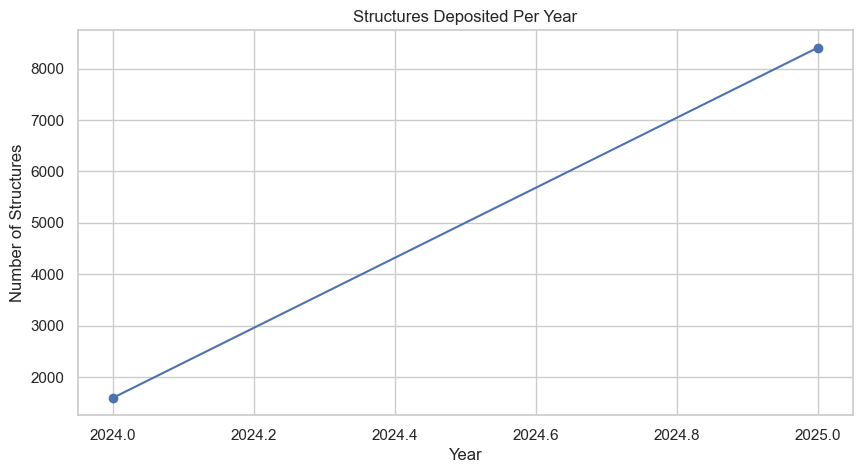

In [7]:
structures_per_year = pdb_df['Deposition_Year'].value_counts().sort_index()
print(pdb_df['Deposition_Year'].value_counts().sort_index())
structures_per_year.plot(kind='line', marker='o', figsize=(10, 5), title='Structures Deposited Per Year')
plt.xlabel("Year")
plt.ylabel("Number of Structures")
plt.grid(True)
plt.show()

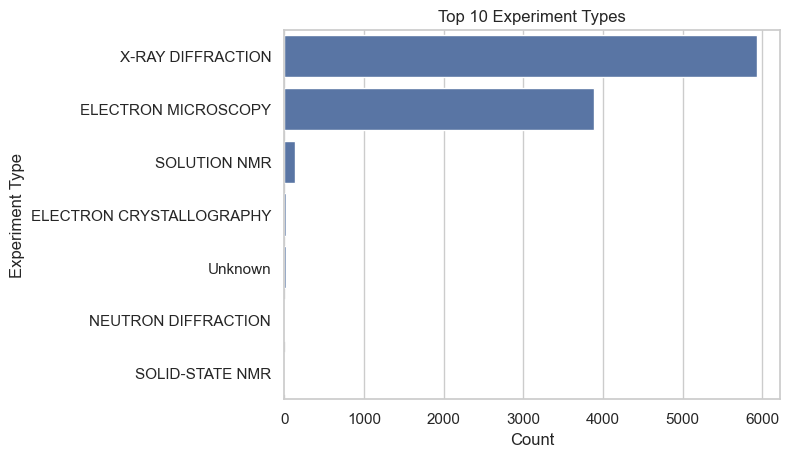

In [8]:
exp_counts = pdb_df['Experiment_Type'].value_counts()
sns.barplot(y=exp_counts.index[:10], x=exp_counts.values[:10])
plt.title("Top 10 Experiment Types")
plt.xlabel("Count")
plt.ylabel("Experiment Type")
plt.show()

Top submitting author: M. (7482 structures)
Least submitting author: Adriaensen (1 structure)


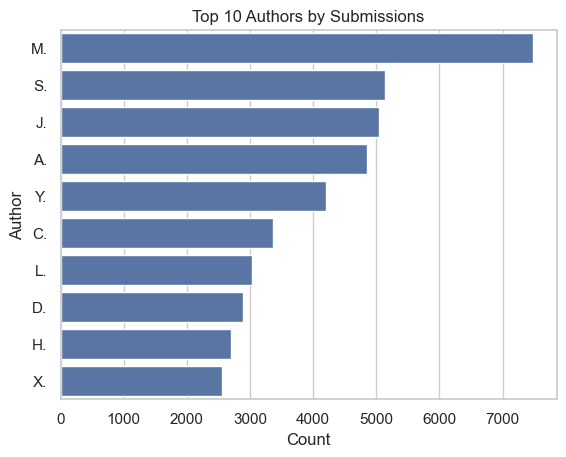

In [11]:
if pdb_df['Authors'].notna().any():
    authors_split = pdb_df['Authors'].str.split(", ").explode()
    author_counts = authors_split.value_counts()

    top_author = author_counts.idxmax()
    top_count = author_counts.max()
    bottom_author = author_counts.idxmin()
    bottom_count = author_counts.min()

    print(f"Top submitting author: {top_author} ({top_count} structures)")
    print(f"Least submitting author: {bottom_author} ({bottom_count} structure)")

    sns.barplot(y=author_counts.index[:10], x=author_counts.values[:10])
    plt.title("Top 10 Authors by Submissions")
    plt.xlabel("Count")
    plt.ylabel("Author")
    plt.show()

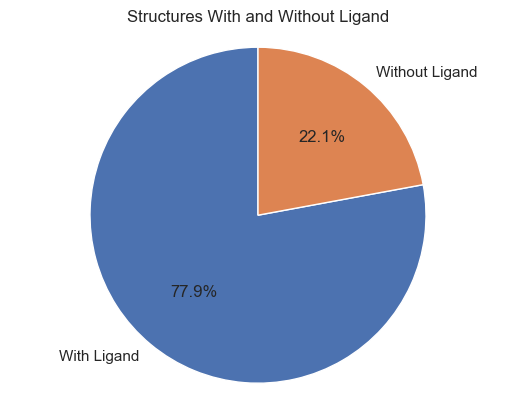

In [12]:
ligand_counts = pdb_df['Has_Ligand'].value_counts()
labels = ['With Ligand' if val else 'Without Ligand' for val in ligand_counts.index]
plt.pie(ligand_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Structures With and Without Ligand")
plt.axis("equal")
plt.show()

In [13]:
pdb_df.to_csv("pdb_metadata.csv", index=False)
print("Saved CSV file.")

Saved CSV file.
